# Tuning Neural Networks with Regularization - Lab

## Introduction

Recall from the last lab that you had a training accuracy close to 90% and a test set accuracy close to 76%.

As with your previous machine learning work, you should be asking a couple of questions:
- Is there high bias? yes/no
- Is there high variance? yes/no 

In this lab, you'll use the a train-validate-test partition as well as a validation set to get better insights of how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. However, this time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test set but also the validation set.

## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Apply dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing you'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [16]:
#Your code here; import some packages/modules you plan to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras

## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [17]:
#Your code here; load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before you begin to practice some of your new tools regarding regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Train - test split
* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding your complaint text
* Transforming your category labels

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your models performance change as you increase (or decrease) the size of your dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [18]:
sample = df.sample(10000, random_state=123)
X = df['Consumer complaint narrative']
y = df['Product']

## Train-test Split

Below, perform an appropriate train test split.

In [19]:
#Yyour code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500,
                                                    random_state=42)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture, you saw that in deep learning, you generally set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test can then be used to define the final model perforance. 

In this example, take the first 1000 cases out of the training set to create a validation set. You should do this for both `train` and `label_train`.

In [20]:
#Just run this block of code 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=1000, 
                                                  random_state=123)

## Preprocessing: One-hot Encoding of the Complaints

As before, you need to do some preprocessing and data manipulationg before building the neural network. 

Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [21]:
#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000) #Initialize a tokenizer.
tokenizer.fit_on_texts(X_train) #Fit it to the complaints

X_train = tokenizer.texts_to_matrix(X_train, mode='binary')
X_val = tokenizer.texts_to_matrix(X_val, mode='binary')

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.

In [22]:
#Your code here; transform the product labels to numerical values
#Then transform these integer values into a matrix of binary flags
from sklearn.preprocessing import LabelBinarizer
from keras.utils.np_utils import to_categorical

encoder = LabelBinarizer()
encoder.fit(y_train)

y_train = to_categorical(encoder.transform(y_train))[:,:,1]
y_val = to_categorical(encoder.transform(y_val))[:,:,1]

## Creating the Model

Rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that you used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because you are dealing with a multiclass problem (classifying the complaints into 7 classes), use a softmax classifyer in order to output 7 class probabilities per case. 

In [8]:
X_train.shape

(57500, 2000)

In [9]:
#Your code here; build a neural network using Keras as described above.
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, include the argument `validation_data` and assign it `(val, label_val)`

In [10]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the Model

Ok, now for the resource intensive part: time to train your model! Note that this is where you also introduce the validation data to the model.

In [11]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(X_train,
                      y_train,
                      epochs=120,
                      batch_size=256,
                      validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/120
57500/57500 [==============================] - 4s 67us/step - loss: 1.8936 - acc: 0.2279 - val_loss: 1.7971 - val_acc: 0.3150
Epoch 2/120
57500/57500 [==============================] - 2s 39us/step - loss: 1.6386 - acc: 0.3787 - val_loss: 1.4641 - val_acc: 0.4980
Epoch 3/120
57500/57500 [==============================] - 2s 40us/step - loss: 1.3012 - acc: 0.5582 - val_loss: 1.1689 - val_acc: 0.6080
Epoch 4/120
57500/57500 [==============================] - 2s 38us/step - loss: 1.0422 - acc: 0.6511 - val_loss: 0.9828 - val_acc: 0.6410
Epoch 5/120
57500/57500 [==============================] - 2s 39us/step - loss: 0.8826 - acc: 0.6947 - val_loss: 0.8746 - val_acc: 0.6720
Epoch 6/120
57500/57500 [==============================] - 2s 37us/step - loss: 0.7878 - acc: 0.7206 - val_loss: 0.8118 - val_acc: 0.6900
Epoch 7/120
57500/57500 [==============================] - 2s 36us/step - loss: 0.7274 - acc: 0.7368 - val_loss: 0.7725 - v

Epoch 118/120
57500/57500 [==============================] - 2s 34us/step - loss: 0.3303 - acc: 0.8831 - val_loss: 0.5994 - val_acc: 0.7960
Epoch 119/120
57500/57500 [==============================] - 2s 35us/step - loss: 0.3294 - acc: 0.8831 - val_loss: 0.6052 - val_acc: 0.7950
Epoch 120/120
57500/57500 [==============================] - 2s 34us/step - loss: 0.3285 - acc: 0.8833 - val_loss: 0.5993 - val_acc: 0.7990


## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [12]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [13]:
results_train = model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

57500/57500 [==============================] - 3s 47us/step
Training Loss: 0.326 Training Accuracy: 0.883


## Preprocess then evaluate our models performance on the test set

In [23]:
X_test = tokenizer.texts_to_matrix(X_test, mode='binary')
y_test = to_categorical(encoder.transform(y_test))[:, :, 1]

results_test = model.evaluate(X_test, y_test)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

1500/1500 [==============================] - 0s 56us/step
Testing Loss: 0.581 Testing Accuracy: 0.789


In [24]:
model.metrics_names

['loss', 'acc']

The first element of the list returned by `model.evaluate` is the loss, and the second is the accuracy score. 

Note that the result you obtained here isn't exactly the same as before. This is because the training set is slightly different! You removed 1000 instances for validation!

## Plotting the Results

Plot the loss function versus the number of epochs. Be sure to include the training and the validation loss in the same plot. Then, create a second plot comparing training and validation accuracy to the number of epochs.

In [25]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

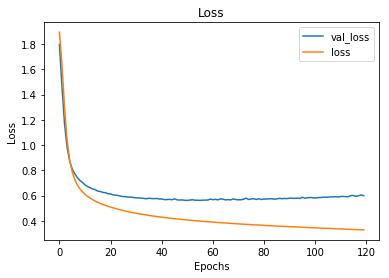

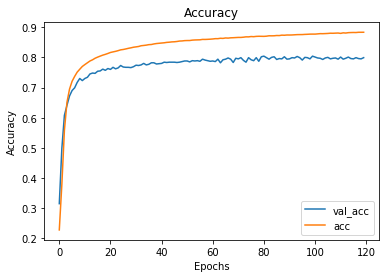

In [26]:
visualize_training_results(model_val)

Notice an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a limit around the 60th epoch. This means that you're probably **overfitting** the model to the training data when you train for many epochs past this dropoff point of around 40 epochs. Luckily, you learned how to tackle overfitting in the previous lecture! Since it seems clear that you are training too long, include early stopping at the 60th epoch first.

## Early Stopping

Below, observe how to update the model to include an earlier cutoff point:

In [28]:
import random
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(X_train,
                        y_train,
                        epochs=60,
                        batch_size=256,
                        validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/60
57500/57500 [==============================] - 2s 39us/step - loss: 1.8298 - acc: 0.2621 - val_loss: 1.6982 - val_acc: 0.3530
Epoch 2/60
57500/57500 [==============================] - 2s 36us/step - loss: 1.4984 - acc: 0.4781 - val_loss: 1.3230 - val_acc: 0.5460
Epoch 3/60
57500/57500 [==============================] - 2s 36us/step - loss: 1.1396 - acc: 0.6373 - val_loss: 1.0314 - val_acc: 0.6490
Epoch 4/60
57500/57500 [==============================] - 2s 35us/step - loss: 0.9155 - acc: 0.6930 - val_loss: 0.8768 - val_acc: 0.6900
Epoch 5/60
57500/57500 [==============================] - 2s 35us/step - loss: 0.7968 - acc: 0.7183 - val_loss: 0.7970 - val_acc: 0.7110
Epoch 6/60
57500/57500 [==============================] - 2s 39us/step - loss: 0.7285 - acc: 0.7354 - val_loss: 0.7458 - val_acc: 0.7280
Epoch 7/60
57500/57500 [==============================] - 2s 42us/step - loss: 0.6840 - acc: 0.7477 - val_loss: 0.7130 - val_acc:

57500/57500 [==============================] - 2s 38us/step - loss: 0.3894 - acc: 0.8614 - val_loss: 0.5576 - val_acc: 0.7910


Now, you can use the test set to make label predictions

In [29]:
results_train = model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test, y_test)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

57500/57500 [==============================] - 3s 53us/step
Training Loss: 0.385 Training Accuracy: 0.864
1500/1500 [==============================] - 0s 65us/step
Testing Loss: 0.554 Testing Accuracy: 0.788


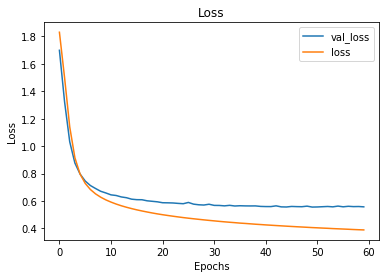

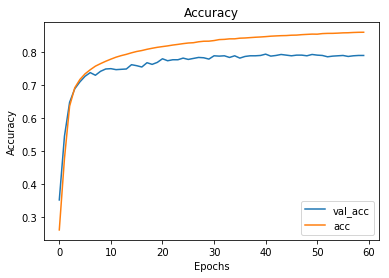

In [30]:
visualize_training_results(final_model)

We've significantly reduced the variance, so this is already pretty good! your test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs model you originally fit.

Now, take a look at how regularization techniques can further improve your model performance.

## L2 Regularization

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [31]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',
                       kernel_regularizer=regularizers.l2(0.005), 
                       input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), 
                       activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(X_train,
                    y_train,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/120
57500/57500 [==============================] - 2s 39us/step - loss: 2.5278 - acc: 0.2338 - val_loss: 2.4413 - val_acc: 0.3090
Epoch 2/120
57500/57500 [==============================] - 2s 31us/step - loss: 2.2723 - acc: 0.4331 - val_loss: 2.1015 - val_acc: 0.5210
Epoch 3/120
57500/57500 [==============================] - 2s 33us/step - loss: 1.8862 - acc: 0.6146 - val_loss: 1.7501 - val_acc: 0.6270
Epoch 4/120
57500/57500 [==============================] - 2s 32us/step - loss: 1.6010 - acc: 0.6851 - val_loss: 1.5422 - val_acc: 0.6640
Epoch 5/120
57500/57500 [==============================] - 2s 31us/step - loss: 1.4389 - acc: 0.7184 - val_loss: 1.4283 - val_acc: 0.6950
Epoch 6/120
57500/57500 [==============================] - 2s 30us/step - loss: 1.3409 - acc: 0.7391 - val_loss: 1.3464 - val_acc: 0.7190
Epoch 7/120
57500/57500 [==============================] - 2s 31us/step - loss: 1.2732 - acc: 0.7528 - val_loss: 1.2965 - v

Epoch 118/120
57500/57500 [==============================] - 2s 30us/step - loss: 0.5398 - acc: 0.8619 - val_loss: 0.6761 - val_acc: 0.8040
Epoch 119/120
57500/57500 [==============================] - 2s 30us/step - loss: 0.5395 - acc: 0.8616 - val_loss: 0.6748 - val_acc: 0.8010
Epoch 120/120
57500/57500 [==============================] - 2s 30us/step - loss: 0.5389 - acc: 0.8618 - val_loss: 0.6741 - val_acc: 0.8050


In [32]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Now, look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

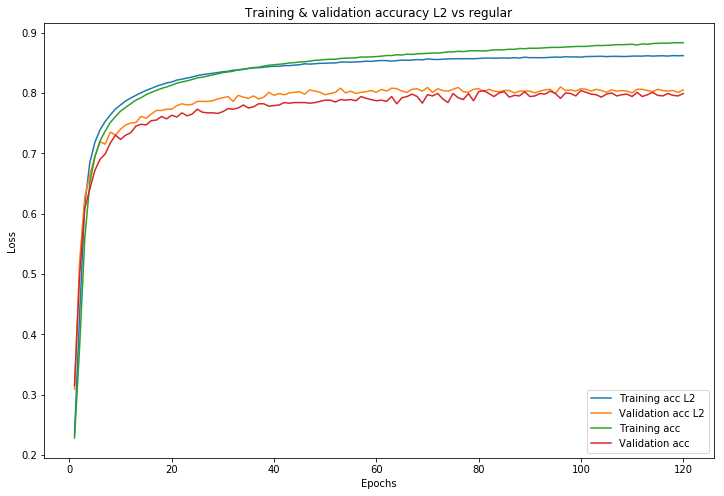

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L2')
ax.plot(epochs, val_acc_values, label='Validation acc L2')
ax.plot(epochs, model_acc, label='Training acc')
ax.plot(epochs, model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Have a look at L1 regularization. Will this work better?

In [35]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',
                       kernel_regularizer=regularizers.l1(0.005), 
                       input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), 
                       activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train,
                     y_train,
                     epochs=120,
                     batch_size=256,
                     validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/120
57500/57500 [==============================] - 2s 35us/step - loss: 13.6744 - acc: 0.2028 - val_loss: 11.1124 - val_acc: 0.2370
Epoch 2/120
57500/57500 [==============================] - 2s 31us/step - loss: 8.9703 - acc: 0.3587 - val_loss: 7.0137 - val_acc: 0.4630
Epoch 3/120
57500/57500 [==============================] - 2s 38us/step - loss: 5.4854 - acc: 0.5491 - val_loss: 4.1628 - val_acc: 0.6000
Epoch 4/120
57500/57500 [==============================] - 2s 35us/step - loss: 3.2583 - acc: 0.6335 - val_loss: 2.5643 - val_acc: 0.6510
Epoch 5/120
57500/57500 [==============================] - 2s 31us/step - loss: 2.2345 - acc: 0.6553 - val_loss: 2.0638 - val_acc: 0.6570
Epoch 6/120
57500/57500 [==============================] - 2s 31us/step - loss: 1.9808 - acc: 0.6602 - val_loss: 1.9281 - val_acc: 0.6570
Epoch 7/120
57500/57500 [==============================] - 2s 33us/step - loss: 1.8662 - acc: 0.6635 - val_loss: 1.8338 -

57500/57500 [==============================] - 2s 31us/step - loss: 0.8612 - acc: 0.7684 - val_loss: 0.9062 - val_acc: 0.7750
Epoch 118/120
57500/57500 [==============================] - 2s 31us/step - loss: 0.8605 - acc: 0.7685 - val_loss: 0.8945 - val_acc: 0.7720
Epoch 119/120
57500/57500 [==============================] - 2s 31us/step - loss: 0.8591 - acc: 0.7695 - val_loss: 0.8964 - val_acc: 0.7650
Epoch 120/120
57500/57500 [==============================] - 2s 31us/step - loss: 0.8576 - acc: 0.7707 - val_loss: 0.8896 - val_acc: 0.7680


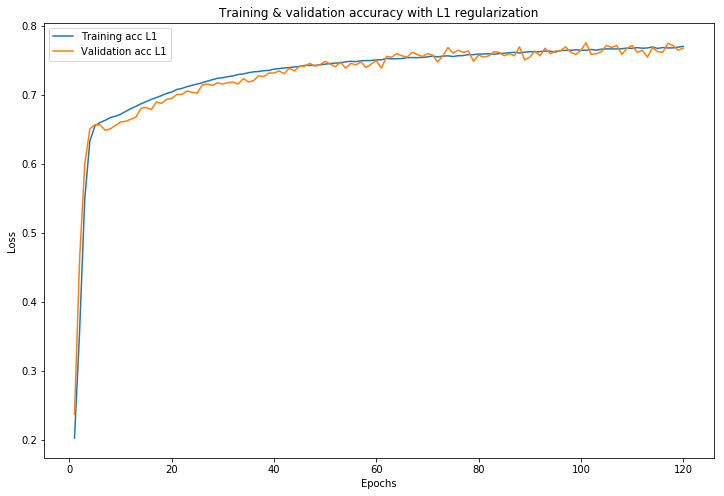

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like you can still improve the model by training much longer.

In [37]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',
                       kernel_regularizer=regularizers.l1(0.005), 
                       input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), 
                       activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train,
                     y_train,
                     epochs=1000,
                     batch_size=256,
                     validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/1000
57500/57500 [==============================] - 2s 36us/step - loss: 13.6801 - acc: 0.2119 - val_loss: 11.1262 - val_acc: 0.2810
Epoch 2/1000
57500/57500 [==============================] - 2s 32us/step - loss: 9.0129 - acc: 0.3353 - val_loss: 7.0688 - val_acc: 0.4220
Epoch 3/1000
57500/57500 [==============================] - 2s 39us/step - loss: 5.5716 - acc: 0.4554 - val_loss: 4.2618 - val_acc: 0.5280
Epoch 4/1000
57500/57500 [==============================] - 2s 42us/step - loss: 3.3725 - acc: 0.5246 - val_loss: 2.6803 - val_acc: 0.5700
Epoch 5/1000
57500/57500 [==============================] - 3s 57us/step - loss: 2.3597 - acc: 0.5542 - val_loss: 2.1942 - val_acc: 0.6020
Epoch 6/1000
57500/57500 [==============================] - 3s 45us/step - loss: 2.1200 - acc: 0.5789 - val_loss: 2.0633 - val_acc: 0.6150
Epoch 7/1000
57500/57500 [==============================] - 2s 37us/step - loss: 1.9982 - acc: 0.5956 - val_loss: 1

57500/57500 [==============================] - 2s 30us/step - loss: 0.8495 - acc: 0.7697 - val_loss: 0.8919 - val_acc: 0.7580
Epoch 118/1000
57500/57500 [==============================] - 2s 31us/step - loss: 0.8490 - acc: 0.7694 - val_loss: 0.8821 - val_acc: 0.7530
Epoch 119/1000
57500/57500 [==============================] - 2s 31us/step - loss: 0.8477 - acc: 0.7705 - val_loss: 0.8846 - val_acc: 0.7570
Epoch 120/1000
57500/57500 [==============================] - 2s 31us/step - loss: 0.8466 - acc: 0.7711 - val_loss: 0.8886 - val_acc: 0.7500
Epoch 121/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.8468 - acc: 0.7699 - val_loss: 0.8811 - val_acc: 0.7590
Epoch 122/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.8450 - acc: 0.7718 - val_loss: 0.8892 - val_acc: 0.7590
Epoch 123/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.8445 - acc: 0.7708 - val_loss: 0.8887 - val_acc: 0.7530
Epoch 124/1000
57500/57500 [

57500/57500 [==============================] - 2s 35us/step - loss: 0.7963 - acc: 0.7837 - val_loss: 0.8441 - val_acc: 0.7610
Epoch 234/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.7941 - acc: 0.7857 - val_loss: 0.8817 - val_acc: 0.7440
Epoch 235/1000
57500/57500 [==============================] - 2s 36us/step - loss: 0.7940 - acc: 0.7850 - val_loss: 0.8289 - val_acc: 0.7690
Epoch 236/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7947 - acc: 0.7843 - val_loss: 0.8299 - val_acc: 0.7680
Epoch 237/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7938 - acc: 0.7865 - val_loss: 0.8337 - val_acc: 0.7720
Epoch 238/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7976 - acc: 0.7835 - val_loss: 0.8366 - val_acc: 0.7610
Epoch 239/1000
57500/57500 [==============================] - 2s 39us/step - loss: 0.7950 - acc: 0.7843 - val_loss: 0.8382 - val_acc: 0.7680
Epoch 240/1000
57500/57500 [

57500/57500 [==============================] - 2s 27us/step - loss: 0.7824 - acc: 0.7871 - val_loss: 0.8680 - val_acc: 0.7540
Epoch 350/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7809 - acc: 0.7887 - val_loss: 0.8275 - val_acc: 0.7750
Epoch 351/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7814 - acc: 0.7877 - val_loss: 0.8495 - val_acc: 0.7610
Epoch 352/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7813 - acc: 0.7875 - val_loss: 0.8291 - val_acc: 0.7740
Epoch 353/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7806 - acc: 0.7875 - val_loss: 0.8232 - val_acc: 0.7660
Epoch 354/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7812 - acc: 0.7870 - val_loss: 0.8280 - val_acc: 0.7730
Epoch 355/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7795 - acc: 0.7885 - val_loss: 0.8715 - val_acc: 0.7400
Epoch 356/1000
57500/57500 [

57500/57500 [==============================] - 2s 28us/step - loss: 0.7761 - acc: 0.7904 - val_loss: 0.8043 - val_acc: 0.7740
Epoch 466/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7736 - acc: 0.7880 - val_loss: 0.8038 - val_acc: 0.7770
Epoch 467/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7746 - acc: 0.7885 - val_loss: 0.8010 - val_acc: 0.7900
Epoch 468/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7810 - acc: 0.7867 - val_loss: 0.8259 - val_acc: 0.7490
Epoch 469/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.7759 - acc: 0.7882 - val_loss: 0.8176 - val_acc: 0.7780
Epoch 470/1000
57500/57500 [==============================] - 2s 37us/step - loss: 0.7720 - acc: 0.7899 - val_loss: 0.8100 - val_acc: 0.7660
Epoch 471/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7731 - acc: 0.7889 - val_loss: 0.8513 - val_acc: 0.7520
Epoch 472/1000
57500/57500 [

57500/57500 [==============================] - 2s 38us/step - loss: 0.7673 - acc: 0.7893 - val_loss: 0.8153 - val_acc: 0.7720
Epoch 582/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7705 - acc: 0.7894 - val_loss: 0.9053 - val_acc: 0.7500
Epoch 583/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7680 - acc: 0.7895 - val_loss: 0.8023 - val_acc: 0.7760
Epoch 584/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7734 - acc: 0.7875 - val_loss: 0.7999 - val_acc: 0.7800
Epoch 585/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7715 - acc: 0.7902 - val_loss: 0.7947 - val_acc: 0.7800
Epoch 586/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7786 - acc: 0.7864 - val_loss: 0.8573 - val_acc: 0.7640
Epoch 587/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7700 - acc: 0.7884 - val_loss: 0.9621 - val_acc: 0.7360
Epoch 588/1000
57500/57500 [

Epoch 639/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.7682 - acc: 0.7885 - val_loss: 0.8197 - val_acc: 0.7770
Epoch 640/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7692 - acc: 0.7881 - val_loss: 0.8119 - val_acc: 0.7770
Epoch 641/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7697 - acc: 0.7893 - val_loss: 0.8378 - val_acc: 0.7730
Epoch 642/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7711 - acc: 0.7883 - val_loss: 0.8155 - val_acc: 0.7640
Epoch 643/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7627 - acc: 0.7914 - val_loss: 0.8251 - val_acc: 0.7670
Epoch 644/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7646 - acc: 0.7896 - val_loss: 0.8237 - val_acc: 0.7690
Epoch 645/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7668 - acc: 0.7901 - val_loss: 0.8141 - val_acc: 0.7680
Epoch 646/100

57500/57500 [==============================] - 2s 28us/step - loss: 0.7677 - acc: 0.7891 - val_loss: 0.7916 - val_acc: 0.7810
Epoch 698/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7639 - acc: 0.7909 - val_loss: 0.8005 - val_acc: 0.7780
Epoch 699/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7691 - acc: 0.7884 - val_loss: 0.8076 - val_acc: 0.7770
Epoch 700/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7614 - acc: 0.7909 - val_loss: 0.8690 - val_acc: 0.7350
Epoch 701/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7712 - acc: 0.7857 - val_loss: 0.8092 - val_acc: 0.7680
Epoch 702/1000
57500/57500 [==============================] - 2s 27us/step - loss: 0.7752 - acc: 0.7864 - val_loss: 0.8316 - val_acc: 0.7790
Epoch 703/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7730 - acc: 0.7858 - val_loss: 0.8462 - val_acc: 0.7560
Epoch 704/1000
57500/57500 [

57500/57500 [==============================] - 2s 34us/step - loss: 0.7653 - acc: 0.7890 - val_loss: 0.7885 - val_acc: 0.7800
Epoch 814/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7651 - acc: 0.7886 - val_loss: 0.7860 - val_acc: 0.7820
Epoch 815/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7588 - acc: 0.7906 - val_loss: 0.8152 - val_acc: 0.7740
Epoch 816/1000
57500/57500 [==============================] - 2s 32us/step - loss: 0.7672 - acc: 0.7881 - val_loss: 0.8474 - val_acc: 0.7510
Epoch 817/1000
57500/57500 [==============================] - 2s 35us/step - loss: 0.7676 - acc: 0.7875 - val_loss: 0.8066 - val_acc: 0.7770
Epoch 818/1000
57500/57500 [==============================] - 2s 35us/step - loss: 0.7627 - acc: 0.7892 - val_loss: 0.8676 - val_acc: 0.7520
Epoch 819/1000
57500/57500 [==============================] - 3s 55us/step - loss: 0.7622 - acc: 0.7881 - val_loss: 0.8343 - val_acc: 0.7650
Epoch 820/1000
57500/57500 [

57500/57500 [==============================] - 2s 27us/step - loss: 0.7618 - acc: 0.7907 - val_loss: 0.7872 - val_acc: 0.7830
Epoch 930/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7648 - acc: 0.7883 - val_loss: 0.8072 - val_acc: 0.7740
Epoch 931/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7585 - acc: 0.7913 - val_loss: 0.7879 - val_acc: 0.7870
Epoch 932/1000
57500/57500 [==============================] - 2s 28us/step - loss: 0.7566 - acc: 0.7899 - val_loss: 0.8285 - val_acc: 0.7460
Epoch 933/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7628 - acc: 0.7896 - val_loss: 0.8184 - val_acc: 0.7740
Epoch 934/1000
57500/57500 [==============================] - 2s 30us/step - loss: 0.7540 - acc: 0.7918 - val_loss: 0.8344 - val_acc: 0.7650
Epoch 935/1000
57500/57500 [==============================] - 2s 29us/step - loss: 0.7660 - acc: 0.7879 - val_loss: 0.8309 - val_acc: 0.7540
Epoch 936/1000
57500/57500 [

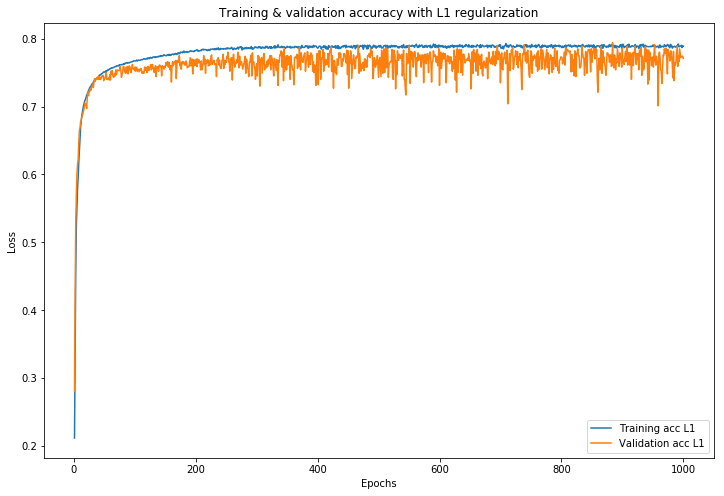

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [40]:
results_train = model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test, y_test)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

57500/57500 [==============================] - 3s 61us/step
Training Loss: 0.753 Training Accuracy: 0.794
1500/1500 [==============================] - 0s 76us/step
Testing Loss: 0.794 Testing Accuracy: 0.77


This is about the best result you've achieved so far, but you were training for quite a while! Next, experiment with dropout regularization to see if it offers any advantages.

## Dropout Regularization

In [41]:
# ⏰ This cell may take about a minute to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(X_train,
                          y_train,
                          epochs=200,
                          batch_size=256,
                          validation_data=(X_val, y_val))

Train on 57500 samples, validate on 1000 samples
Epoch 1/200
57500/57500 [==============================] - 3s 58us/step - loss: 1.9376 - acc: 0.1825 - val_loss: 1.8847 - val_acc: 0.2510
Epoch 2/200
57500/57500 [==============================] - 3s 53us/step - loss: 1.8609 - acc: 0.2497 - val_loss: 1.7343 - val_acc: 0.3630
Epoch 3/200
57500/57500 [==============================] - 3s 54us/step - loss: 1.7366 - acc: 0.3197 - val_loss: 1.5255 - val_acc: 0.4860
Epoch 4/200
57500/57500 [==============================] - 3s 58us/step - loss: 1.5957 - acc: 0.3781 - val_loss: 1.3467 - val_acc: 0.5650
Epoch 5/200
57500/57500 [==============================] - 4s 63us/step - loss: 1.4788 - acc: 0.4279 - val_loss: 1.2047 - val_acc: 0.6370
Epoch 6/200
57500/57500 [==============================] - 3s 56us/step - loss: 1.3753 - acc: 0.4753 - val_loss: 1.0915 - val_acc: 0.6750
Epoch 7/200
57500/57500 [==============================] - 3s 51us/step - loss: 1.2989 - acc: 0.5090 - val_loss: 1.0022 - v

Epoch 118/200
57500/57500 [==============================] - 3s 48us/step - loss: 0.6469 - acc: 0.7629 - val_loss: 0.5274 - val_acc: 0.8100
Epoch 119/200
57500/57500 [==============================] - 3s 49us/step - loss: 0.6480 - acc: 0.7636 - val_loss: 0.5266 - val_acc: 0.8110
Epoch 120/200
57500/57500 [==============================] - 3s 48us/step - loss: 0.6476 - acc: 0.7652 - val_loss: 0.5241 - val_acc: 0.8120
Epoch 121/200
57500/57500 [==============================] - 3s 49us/step - loss: 0.6422 - acc: 0.7653 - val_loss: 0.5254 - val_acc: 0.8120
Epoch 122/200
57500/57500 [==============================] - 3s 48us/step - loss: 0.6448 - acc: 0.7645 - val_loss: 0.5242 - val_acc: 0.8110
Epoch 123/200
57500/57500 [==============================] - 3s 49us/step - loss: 0.6369 - acc: 0.7690 - val_loss: 0.5240 - val_acc: 0.8110
Epoch 124/200
57500/57500 [==============================] - 3s 48us/step - loss: 0.6497 - acc: 0.7638 - val_loss: 0.5235 - val_acc: 0.8140
Epoch 125/200
57500/

In [43]:
results_train = model.evaluate(X_train, y_train)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test, y_test)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

57500/57500 [==============================] - 3s 59us/step
Training Loss: 0.376 Training Accuracy: 0.874
1500/1500 [==============================] - 0s 104us/step
Testing Loss: 0.491 Testing Accuracy: 0.803


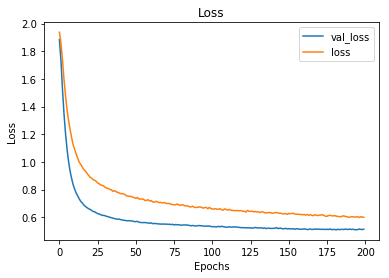

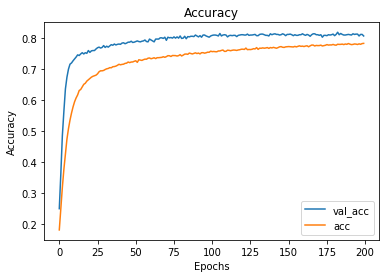

In [46]:
visualize_training_results(dropout_model)

You can see here that the validation performance has improved again! The variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. You actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple your data set, and see what happens. Note that you are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [47]:
df = pd.read_csv('Bank_complaints.csv')
df = df.sample(40000, random_state=123)

X = df["Consumer complaint narrative"]
y = df["Product"]

# train test split
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X, y, random_state=42)

#Validation set
X_train_final_lrg, X_val_lrg, y_train_final_lrg, y_val_lrg = train_test_split(X_train_lrg, y_train_lrg, random_state=123)


#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_lrg)

X_train_tok_lrg = tokenizer.texts_to_matrix(X_train_final_lrg, mode='binary')
X_val_lrg = tokenizer.texts_to_matrix(X_val_lrg, mode='binary')
X_test_lrg = tokenizer.texts_to_matrix(X_test_lrg, mode='binary')

#one-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_lrg)

y_train_lb_lrg = to_categorical(lb.transform(y_train_final_lrg))[:, :, 1]
y_val_lrg = to_categorical(lb.transform(y_val_lrg))[:, :, 1]
y_test_lrg = to_categorical(lb.transform(y_test_lrg))[:, :, 1]

In [48]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(X_train_tok_lrg,
                           y_train_lb_lrg,
                           epochs=120,
                           batch_size=256,
                           validation_data=(X_val_lrg, y_val_lrg))

Train on 22500 samples, validate on 7500 samples
Epoch 1/120
22500/22500 [==============================] - 2s 75us/step - loss: 1.9405 - acc: 0.1784 - val_loss: 1.9125 - val_acc: 0.2315
Epoch 2/120
22500/22500 [==============================] - 1s 44us/step - loss: 1.8919 - acc: 0.2610 - val_loss: 1.8635 - val_acc: 0.2924
Epoch 3/120
22500/22500 [==============================] - 1s 42us/step - loss: 1.8300 - acc: 0.3168 - val_loss: 1.7848 - val_acc: 0.3452
Epoch 4/120
22500/22500 [==============================] - 1s 43us/step - loss: 1.7319 - acc: 0.3808 - val_loss: 1.6679 - val_acc: 0.4115
Epoch 5/120
22500/22500 [==============================] - 1s 47us/step - loss: 1.6012 - acc: 0.4476 - val_loss: 1.5289 - val_acc: 0.4869
Epoch 6/120
22500/22500 [==============================] - 1s 42us/step - loss: 1.4586 - acc: 0.5247 - val_loss: 1.3867 - val_acc: 0.5540
Epoch 7/120
22500/22500 [==============================] - 1s 43us/step - loss: 1.3193 - acc: 0.5805 - val_loss: 1.2536 - v

Epoch 118/120
22500/22500 [==============================] - 1s 39us/step - loss: 0.2973 - acc: 0.9012 - val_loss: 0.6056 - val_acc: 0.7949
Epoch 119/120
22500/22500 [==============================] - 1s 42us/step - loss: 0.2957 - acc: 0.9019 - val_loss: 0.6057 - val_acc: 0.7943
Epoch 120/120
22500/22500 [==============================] - 1s 42us/step - loss: 0.2944 - acc: 0.9019 - val_loss: 0.6091 - val_acc: 0.7951


In [49]:
results_train = model.evaluate(X_train_tok_lrg, y_train_lb_lrg)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_lrg, y_test_lrg)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

22500/22500 [==============================] - 1s 51us/step
Training Loss: 0.29 Training Accuracy: 0.904
10000/10000 [==============================] - 1s 63us/step
Testing Loss: 0.61 Testing Accuracy: 0.791


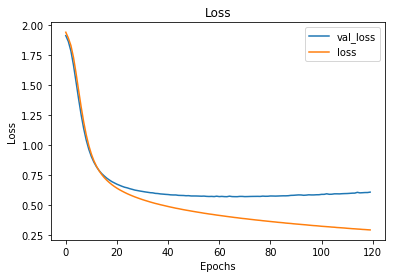

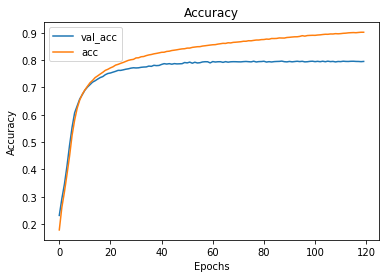

In [51]:
visualize_training_results(moredata_model)

With the same amount of epochs, you were able to get a fairly similar validation accuracy of 89.67 (compared to 88.45 in obtained in the first model in this lab). Your test set accuracy went up from 75.8 to 79.2% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, you not only built an initial deep-learning model, you then used a validation set to tune your model using various types of regularization.